# scratch

In [2]:
import sys
sys.path.append('../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import os
import healpy as hp
from illustris_frb import frb_simulation
import time

figpath = '/home/tnguser/frb_project/figures'
gcat_dir = '/home/tnguser/frb_project/data/g_cats'

In [7]:
origin = 500 * np.array([50, 70, 23])
sim = frb_simulation('L205n2500TNG', origin=origin)

z = 0.4
x = sim.comoving_distance(z)

In [4]:
# compute angular size of a bin at z = 0.4, in arcmin
print(f'Angular size of {sim.binsize} ckpc/h bin at z={z}: {np.degrees(sim.binsize / x)*60:.2f}\'')

Angular size of 500 ckpc/h bin at z=0.4: 1.59'


In [5]:
# estimate angular distance between consecutive bad rays (lower bound), in degrees
print(f'Lower bound on angular distance between consecutive bad rays: {np.degrees(np.arcsin(sim.boxsize / x)):.2f} deg')

Lower bound on angular distance between consecutive bad rays: 10.91 deg


In [8]:
# npix corresponding to this angular scale
nside = 512
print(f"Approximate resolution at nside {nside} is {hp.nside2resol(nside, arcmin=True):.1f}\'")

npix = hp.nside2npix(nside)
pixels = np.arange(npix)
print(f"Number of pixels: {npix}")

Approximate resolution at nside 512 is 6.9'
Number of pixels: 3145728


## getting all bad sky regions via brute force

In [61]:
nside = 64
print(f"Approximate resolution at nside {nside} is {hp.nside2resol(nside, arcmin=True)/60:.1f} deg")

npix = hp.nside2npix(nside)
pixels = np.arange(npix)
print(f"Number of pixels: {npix}")

Approximate resolution at nside 64 is 0.9 deg
Number of pixels: 49152


In [62]:
start=time.time()
thetas, phis = hp.pix2ang(nside=nside, ipix=pixels)
max_dists = sim.get_max_dist(thetas, phis)

print(f'Compute time: {time.time()-start:.2f} s')

Compute time: 40.95 s


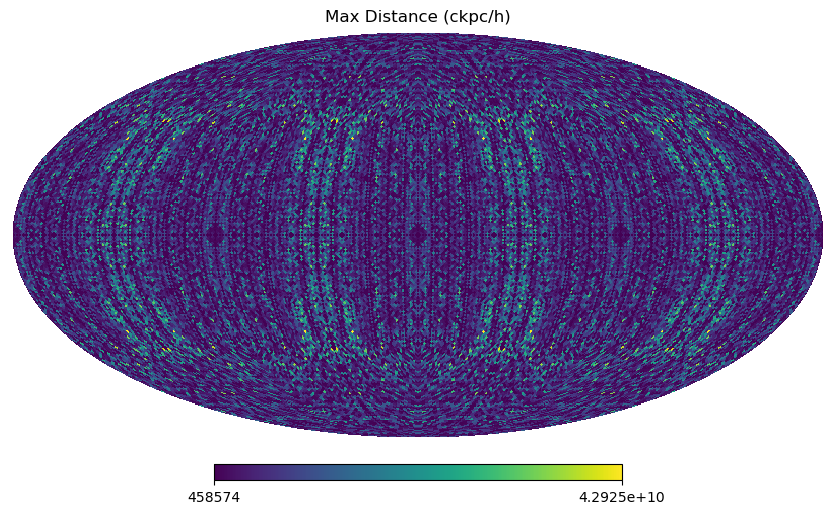

In [63]:
hp.mollview(max_dists, title="Max Distance (ckpc/h)")

In [ ]:
#why tf do these holes on theta=pi/2 exist they should not

In [64]:
#cap at z = 2
x2 = sim.comoving_distance(2)

max_dists_ = np.array(max_dists)
max_dists_[ max_dists > x2 ] = x2

max_zs = sim.z_from_dist(max_dists_)

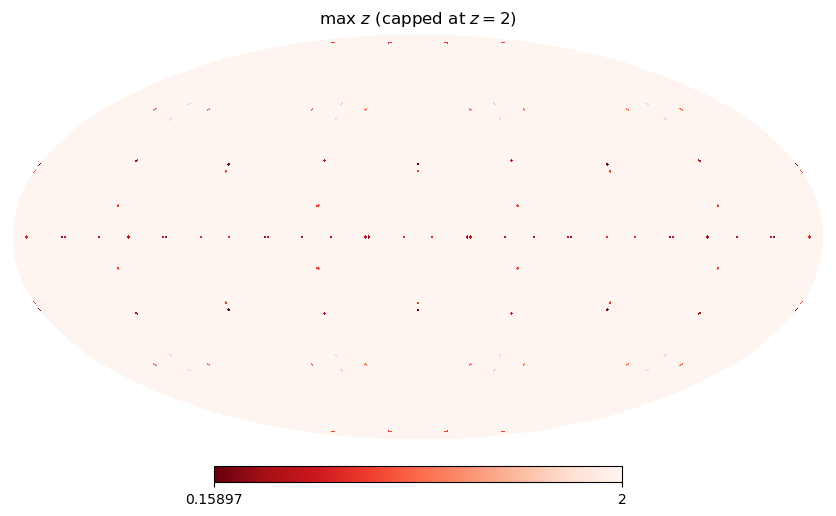

In [67]:
cmap = plt.colormaps['Reds'].reversed()
hp.mollview(max_zs, title=r"max $z$ (capped at $z=2$)", cmap=cmap)

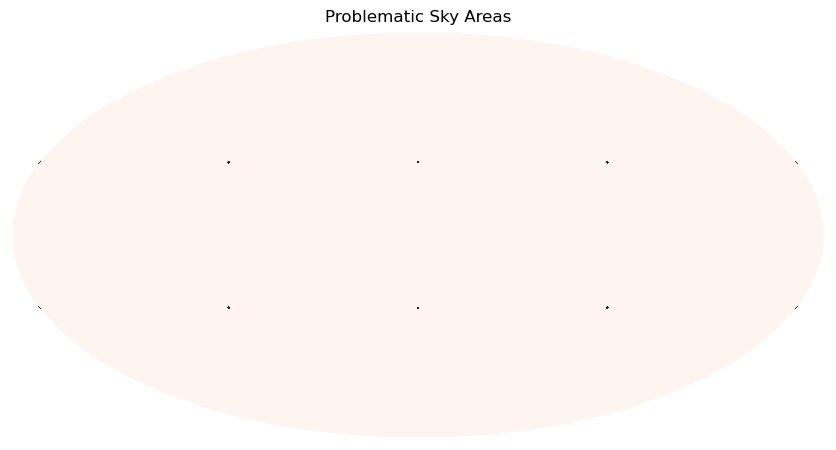

In [68]:
hp.mollview(max_zs > 0.4, title=r"Problematic Sky Areas", cmap=cmap, cbar=False)

In [70]:
np.nonzero(max_zs < 0.4) #indices of problematic pixels

(array([13440, 13504, 13568, 13632, 35456, 35520, 35584, 35648]),)

This is not very helpful because the angular resolution of the pixels is not good enough to pick out all the problematic points--and it would be too computationally prohibitive to do so.

## get all bad sky regions by thinking about it xd

We have to think about all integer vectors with $|\vec{v}| \leq \frac{x}{\mathrm{boxsize}}$. We can do this via:

In [5]:
def get_bad_vecs(x, boxsize):
    
    n = int(np.ceil(x/boxsize))
    vecs = np.indices((2*n+1, 2*n+1, 2*n+1)).reshape((3, (2*n+1)**3)).T - n # integer vecs in cube
    vecs = vecs[ np.any(vecs, axis=1) ] # get rid of (0,0,0)
    
    gcd = np.gcd(np.gcd(vecs[:,0], vecs[:,1]), vecs[:,2])
    vecs = np.unique(np.floor_divide(vecs.T, gcd).T, axis=0) # get rid of vectors that point in the same direction
    
    return vecs[ (norm(vecs, axis=1) <= x/boxsize) ] 

Applying to our simulation at $z=0.4$:

In [8]:
bad_vecs = get_bad_vecs(x, sim.boxsize)

# spherical coordinates
bad_thetas, bad_phis = hp.vec2ang(bad_vecs)

In [9]:
# visualize

nside = 64
print(f"Resolution: {hp.nside2resol(nside, arcmin=True):.1f}\'")

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
pix_arr = np.zeros(hp.nside2npix(nside))
pix_arr[ bad_pixels ] = 1 

Resolution: 55.0'


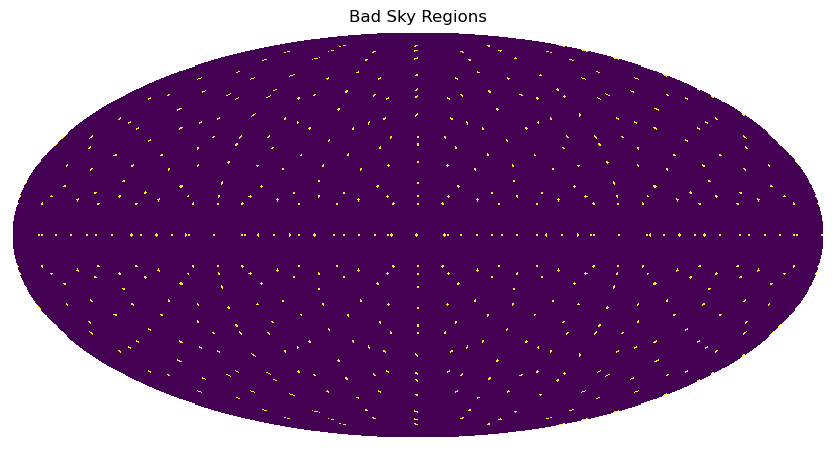

In [88]:
hp.mollview(pix_arr, title="Bad Sky Regions", cbar=False)

Focusing our attention to the points near the equatorial plane:

In [139]:
mask = np.isclose(bad_thetas, np.pi/2)

In [147]:
bad_eq_phis = np.sort(bad_phis[mask])
np.degrees(bad_eq_phis)

array([  0.        ,  11.30993247,  14.03624347,  18.43494882,
        26.56505118,  33.69006753,  36.86989765,  45.        ,
        53.13010235,  56.30993247,  63.43494882,  71.56505118,
        75.96375653,  78.69006753,  90.        , 101.30993247,
       104.03624347, 108.43494882, 116.56505118, 123.69006753,
       126.86989765, 135.        , 143.13010235, 146.30993247,
       153.43494882, 161.56505118, 165.96375653, 168.69006753,
       180.        , 191.30993247, 194.03624347, 198.43494882,
       206.56505118, 213.69006753, 216.86989765, 225.        ,
       233.13010235, 236.30993247, 243.43494882, 251.56505118,
       255.96375653, 258.69006753, 270.        , 281.30993247,
       284.03624347, 288.43494882, 296.56505118, 303.69006753,
       306.86989765, 315.        , 323.13010235, 326.30993247,
       333.43494882, 341.56505118, 345.96375653, 348.69006753])

In [151]:
np.ediff1d(np.degrees(bad_eq_phis)) #width of safe equatorial regions, in degrees

array([11.30993247,  2.72631099,  4.39870535,  8.13010235,  7.12501635,
        3.17983012,  8.13010235,  8.13010235,  3.17983012,  7.12501635,
        8.13010235,  4.39870535,  2.72631099, 11.30993247, 11.30993247,
        2.72631099,  4.39870535,  8.13010235,  7.12501635,  3.17983012,
        8.13010235,  8.13010235,  3.17983012,  7.12501635,  8.13010235,
        4.39870535,  2.72631099, 11.30993247, 11.30993247,  2.72631099,
        4.39870535,  8.13010235,  7.12501635,  3.17983012,  8.13010235,
        8.13010235,  3.17983012,  7.12501635,  8.13010235,  4.39870535,
        2.72631099, 11.30993247, 11.30993247,  2.72631099,  4.39870535,
        8.13010235,  7.12501635,  3.17983012,  8.13010235,  8.13010235,
        3.17983012,  7.12501635,  8.13010235,  4.39870535,  2.72631099])

Now, let's get the equatorial unsafe points

In [145]:
safe_dtheta = np.amin(np.abs(bad_thetas[~mask] - np.pi/2))
print(f'The band of latitudes of +/-{safe_dtheta:.2f} rad or +/-{np.degrees(safe_dtheta):.2f} deg is safe, barring equatorial unsafe points')

The band of latitudes of +/-0.19 rad or +/-11.10 deg is safe, barring equatorial unsafe points


In [165]:
#get indices where we are close to the maximum
safe_eq_indices = np.nonzero(np.isclose(np.ediff1d(np.degrees(bad_eq_phis)), np.amax(np.ediff1d(np.degrees(bad_eq_phis)))))[0]

#print safe regions in degrees
print(f'-{np.degrees(safe_dtheta):.2f} < theta - 90 < {np.degrees(safe_dtheta):.2f}\n')
for i in safe_eq_indices:
    print(f'{np.degrees(bad_eq_phis)[i]:.2f} < phi < {np.degrees(bad_eq_phis)[i+1]:.2f}')

-11.10 < theta - 90 < 11.10

0.00 < phi < 11.31
78.69 < phi < 90.00
90.00 < phi < 101.31
168.69 < phi < 180.00
180.00 < phi < 191.31
258.69 < phi < 270.00
270.00 < phi < 281.31


In [168]:
#print safe regions in radians
print(f'dtheta = {safe_dtheta:.3f}')
print(f'{-safe_dtheta+(np.pi/2):.3f} < theta < {safe_dtheta+(np.pi/2):.3f}\n')
for i in safe_eq_indices:
    print(f'{bad_eq_phis[i]:.3f} < phi < {bad_eq_phis[i+1]:.3f}')

dtheta = 0.194
1.377 < theta < 1.764

0.000 < phi < 0.197
1.373 < phi < 1.571
1.571 < phi < 1.768
2.944 < phi < 3.142
3.142 < phi < 3.339
4.515 < phi < 4.712
4.712 < phi < 4.910


In [171]:
print(f'Error margin: {sim.binsize / x} rad')

Error margin: 0.0004615323070754232 rad


In [172]:
sim.boxsize / x

0.18922824590092352

### get pixels for our first test region

In [4]:
theta_min = np.pi/2 - 0.09
theta_max = np.pi/2 + 0.09
phi_min = 0.01
phi_max = 0.19 

In [5]:
nside = 128
r = hp.max_pixrad(nside) #radius of pixel in radians

In [6]:
#get all pixels in this box
pixels = hp.query_strip(nside, theta_min+r, theta_max-r)
thetas, phis = hp.pix2ang(nside, pixels)
mask = (phi_min+r < phis) & (phis < phi_max-r)

pixels = pixels[mask]
np.save(os.path.join(gcat_dir, f'test_pixels_nside{nside}'), pixels)
print(len(pixels))
pixels

418


array([ 90370,  90371,  90372,  90373,  90374,  90375,  90376,  90377,
        90378,  90379,  90380,  90381,  90382,  90881,  90882,  90883,
        90884,  90885,  90886,  90887,  90888,  90889,  90890,  90891,
        90892,  90893,  90894,  91394,  91395,  91396,  91397,  91398,
        91399,  91400,  91401,  91402,  91403,  91404,  91405,  91406,
        91905,  91906,  91907,  91908,  91909,  91910,  91911,  91912,
        91913,  91914,  91915,  91916,  91917,  91918,  92418,  92419,
        92420,  92421,  92422,  92423,  92424,  92425,  92426,  92427,
        92428,  92429,  92430,  92929,  92930,  92931,  92932,  92933,
        92934,  92935,  92936,  92937,  92938,  92939,  92940,  92941,
        92942,  93442,  93443,  93444,  93445,  93446,  93447,  93448,
        93449,  93450,  93451,  93452,  93453,  93454,  93953,  93954,
        93955,  93956,  93957,  93958,  93959,  93960,  93961,  93962,
        93963,  93964,  93965,  93966,  94466,  94467,  94468,  94469,
      

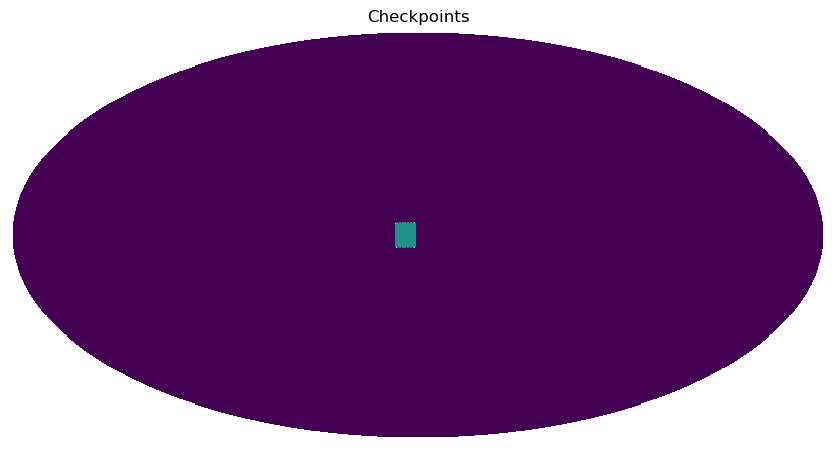

In [7]:
#testing checkpoints
pix_arr = np.zeros(hp.nside2npix(nside))
pix_arr[ pixels ] = 0.5
pix_arr[[90370, 90894, 105730, 105742]] = 1
hp.mollview(pix_arr, title="Checkpoints", cbar=False)

# new 

In [1]:
import sys
sys.path.append('../')
from illustris_frb import frb_simulation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import os
import healpy as hp
from astropy import units as u

In [5]:
figpath = '../figures'

origin = 500 * np.array([50, 70, 23])
sim = frb_simulation(origin=origin)

## Constraint #1: A ray cannot cross the same region twice 

The bad rays are ones that are an integer multiple of the simulation box size. Therefore, we have to think about all integer vectors with $|\vec{v}| \leq \frac{x}{\mathrm{boxsize}}$, where $x$ is the distance between the source and origin. We can do this via:

In [6]:
def get_bad_vecs(z, boxsize=sim.boxsize):

    x = sim.comoving_distance(z)
    
    n = int(np.ceil(x/boxsize))
    vecs = np.indices((2*n+1, 2*n+1, 2*n+1)).reshape((3, (2*n+1)**3)).T - n # integer vecs in cube
    vecs = vecs[ np.any(vecs, axis=1) ] # get rid of (0,0,0)
    
    gcd = np.gcd(np.gcd(vecs[:,0], vecs[:,1]), vecs[:,2])
    vecs = np.unique(np.floor_divide(vecs.T, gcd).T, axis=0) # get rid of vectors that point in the same direction
    
    return vecs[ (norm(vecs, axis=1) <= x/boxsize) ] 

In [10]:
nside = 128
print(f"Resolution: {hp.nside2resol(nside, arcmin=True):.1f}\'")

npix = hp.nside2npix(nside)

Resolution: 27.5'


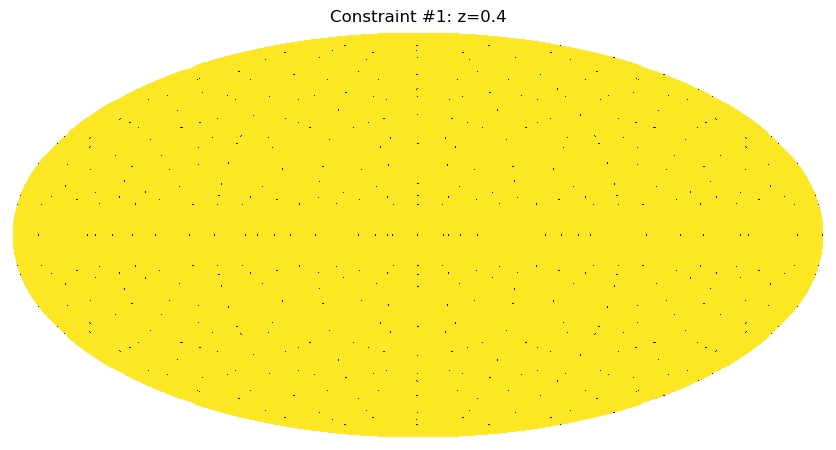

In [11]:
bad_vecs = get_bad_vecs(0.4)

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
goodpix_1_z04 = np.ones(npix)
goodpix_1_z04[ bad_pixels ] = 0

hp.mollview(goodpix_1_z04, title='Constraint #1: z=0.4', cbar=False)

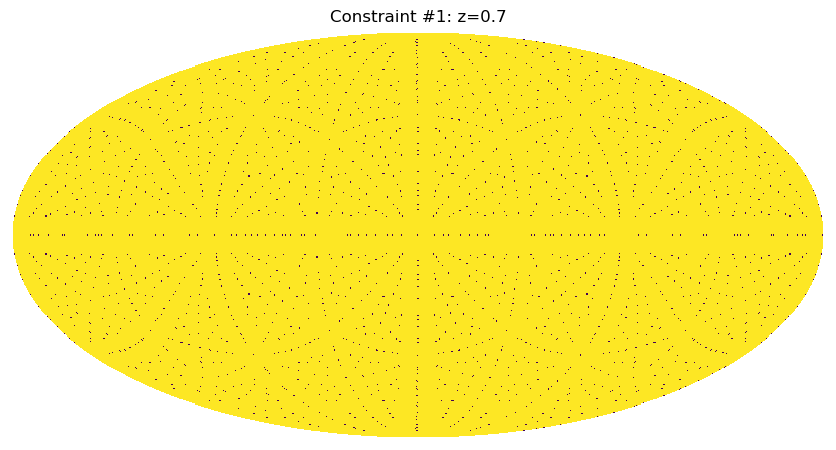

In [8]:
bad_vecs = get_bad_vecs(0.7)

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
goodpix_1_z07 = np.ones(npix)
goodpix_1_z07[ bad_pixels ] = 0

hp.mollview(goodpix_1_z07, title='Constraint #1: z=0.7', cbar=False)

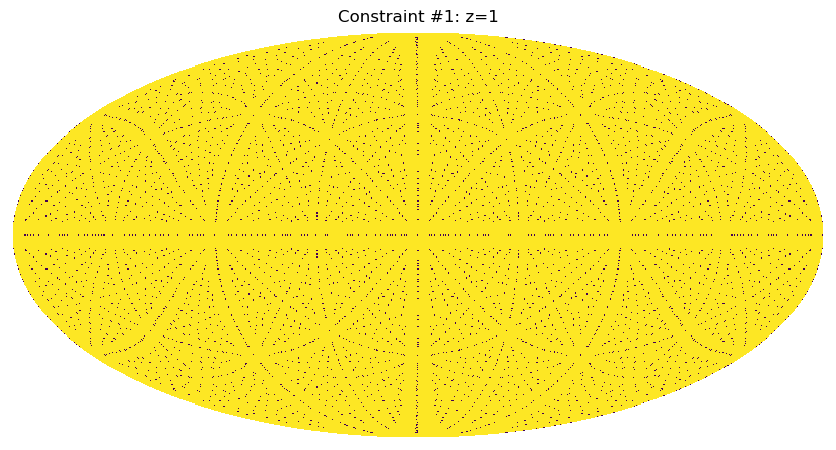

In [9]:
bad_vecs = get_bad_vecs(1)

bad_pixels = hp.vec2pix(nside, x=bad_vecs[:,0], y=bad_vecs[:,1], z=bad_vecs[:,2])
goodpix_1_z1 = np.ones(hp.nside2npix(nside))
goodpix_1_z1[ bad_pixels ] = 0

hp.mollview(goodpix_1_z1, title='Constraint #1: z=1', cbar=False)

# Constraint #2: Adjacent rays should not encounter the same structures in different boxes 

Consider the ray going from the origin to the center of the sky region of interest. This ray, repeated in stacked periodic boxes, represents lines (images) that cannot not be crossed. Previously, we imposed the constraint that the ray cannot intersect its own images. Now, we introduce the constraint that nearby rays within the sky region also cannot cross this image, since that introduces spatial correlations dependent on the geometry of the configuration.

Let the origin be $\vec{u}$, such that the ray is given by $\vec{u} + t\vec{v}$. A line "image" would be given by $\vec{u^\prime} + t\vec{v}$, where $\vec{u^\prime} - \vec{u}$ is an adjacent periodic box (e.g. $s \cdot (1,0,0)$, where $s$ is the simulation box size). Then, the distance between these two images is $d = \hat{v} \times (\vec{u^\prime} - \vec{u})$. The radius of the sky region cannot be bigger than $d - 10\,\mathrm{Mpc}$ (to allow for macroscopic structures).

In [7]:
def get_d(v, s=sim.boxsize):
    vhat = np.abs(v)/np.atleast_2d(norm(np.atleast_2d(v), axis=1)).T
    dists = []
    for check in np.mgrid[0:2, 0:2, 0:2].T.reshape(8,3)[1:]:
        dists.append(norm(np.atleast_2d(np.cross(vhat, check)), axis=1))
    res = s*np.amin(np.vstack(dists), axis=0)
    if v.ndim < 2:
        return res[0]
    return res

def get_comoving_subtended_size(z, theta):
    #z is where FRBs are located
    #theta is the angular size of the region

    return (sim.cosmo.kpc_proper_per_arcmin(z)*theta*u.rad - 10*u.Mpc).to(u.Mpc)*(1+z)*sim.h

In [20]:
# in flat_sky, our sky region has size 0.18 rad, with FRBs at z = 0.4. This distance minus 10 Mpc, in ckpc/h:

get_comoving_subtended_size(0.4, 0.18)

<Quantity 185.5190003 Mpc>

In [21]:
# what about a smaller region?

get_comoving_subtended_size(0.4, 0.1)

<Quantity 98.85117794 Mpc>

Text(0.5, 1.0, 'Subtended Size of Sky Region (cMpc/h)')

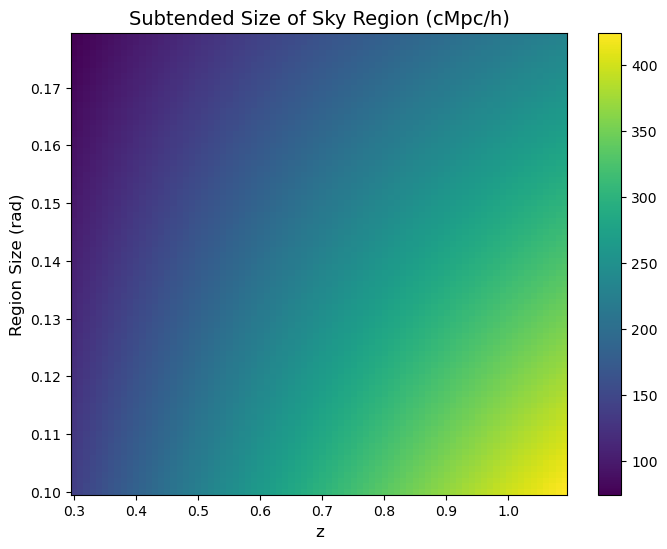

In [23]:
zs, thetas = np.meshgrid(np.arange(0.3, 1.1, 0.01), np.arange(0.1, 0.18, 0.001))
ds_arr = get_comoving_subtended_size(zs, thetas)

fig, ax = plt.subplots(figsize=(8,6))
pos = ax.imshow(ds_arr.value, aspect='auto', extent=(0.295, 1.095, 0.0995, 0.1795))
fig.colorbar(pos, ax=ax, location='right')
ax.set_xlabel('z', fontsize=12)
ax.set_ylabel('Region Size (rad)', fontsize=12)
ax.set_title('Subtended Size of Sky Region (cMpc/h)', fontsize=14)

In [12]:
#let's look at which regions have an allowed region size greater than 88000 ckpc/h:

pixels = np.arange(npix)

vecs = np.vstack(hp.pix2vec(nside=nside, ipix=pixels)).T
ds = get_d(vecs)

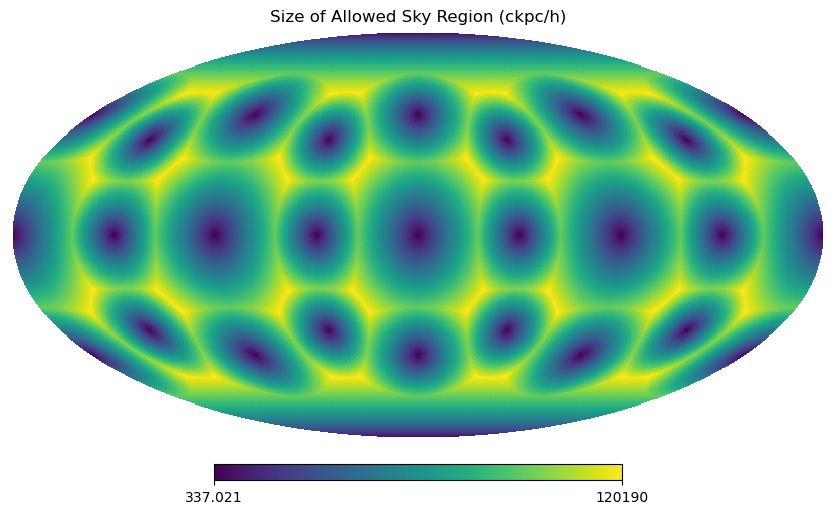

In [57]:
hp.mollview(ds, title="Size of Allowed Sky Region (ckpc/h)")

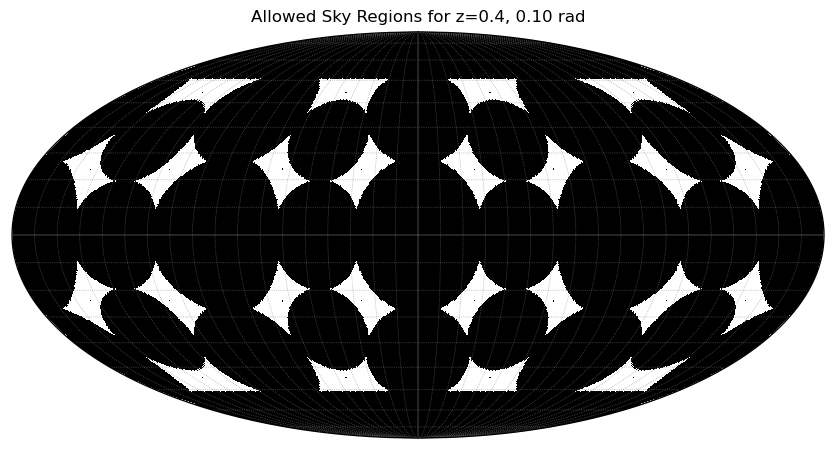

In [19]:
# overplot with constraint #1

goodpix_2 = ds > get_comoving_subtended_size(0.4, 0.1).to(u.kpc).value

hp.mollview(goodpix_1_z04 * goodpix_2, title="Allowed Sky Regions for z=0.4, 0.10 rad", cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.5, color='gray', alpha=0.8)
plt.savefig(os.path.join(figpath, 'allowed_sky_regions_z04_10.png'), dpi=200, bbox_inches='tight')

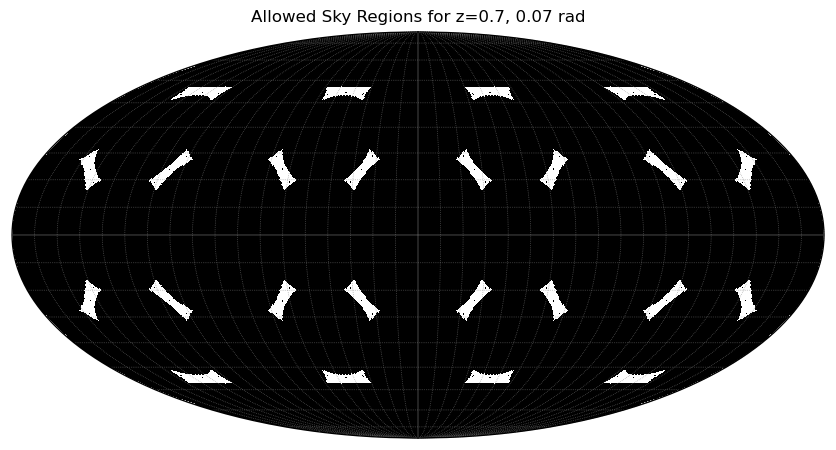

In [90]:
goodpix_2 = ds > get_comoving_subtended_size(0.7, 0.07).to(u.kpc).value

hp.mollview(goodpix_1_z07 * goodpix_2, title="Allowed Sky Regions for z=0.7, 0.07 rad", cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.5, color='gray', alpha=0.8)
plt.savefig(os.path.join(figpath, 'allowed_sky_regions_z07_07.png'), dpi=200, bbox_inches='tight')

In [18]:
goodpix_2 = ds > get_comoving_subtended_size(1, 0.05).to(u.kpc).value

hp.mollview(goodpix_1_z1 * goodpix_2, title="Allowed Sky Regions for z=1.0, 0.05 rad", cmap=plt.colormaps['Grays'].reversed(), cbar=False)
hp.visufunc.graticule(10, 10, lw=0.5, color='gray', alpha=0.8)
plt.savefig(os.path.join(figpath, 'allowed_sky_regions_z10_05.png'), dpi=200, bbox_inches='tight')

NameError: name 'goodpix_1_z1' is not defined

## finding regions manually 

In [8]:
from illustris_frb.utils import Rodrigues

# def rotate(theta1, phi1, dtheta, dphi):
#     """
#     Converts between two spherical coordinate systems, (theta0, phi0) and
#     (theta1, phi1). The forward transformation (0 to 1) occurs by rotating
#     azimuthally by -dphi, then transforming into a system with a pole at 
#     (dtheta, np.pi/2).
#     """

#     theta0 = np.arccos( np.cos(theta1)*np.cos(dtheta) - np.sin(theta1)*np.sin(dtheta)*np.sin(phi1) )
#     phi0 = np.arccos( np.sin(theta1)*np.cos(phi1) / np.sin(theta0) ) * \
#            np.sign( ( np.cos(theta1)*np.sin(dtheta) + np.sin(theta1)*np.cos(dtheta)*np.sin(phi1) ) / np.cos(theta0) )

#     return theta0, np.mod(phi0+dphi, 2*np.pi)

In [31]:
def plotregion(k, theta, dphi): #in degrees, for z=0.4, 0.1x0.1 rad region
    if len(k) == 2:
        k = hp.ang2vec(*k)
    elif len(k)==3:
        k = np.asarray(k)
    R = Rodrigues(k, theta)
    
    thetas_, phis_ = np.meshgrid(np.pi/2+np.arange(-0.05, 0.0505, 0.001), np.arange(-0.05, 0.0505, 0.001))
    thetas, phis = hp.vec2ang(
        np.matmul(R, np.atleast_2d(hp.ang2vec(thetas_.flatten(), phis_.flatten())).T).T
    )

    regionpix = goodpix_1_z04 * goodpix_2
    ipix = np.unique(hp.ang2pix(nside, thetas, phis+dphi))
    regionpix[ ipix ] = 0.5

    hp.mollview(regionpix, title=None, cmap=plt.colormaps['Grays'].reversed(), cbar=False)

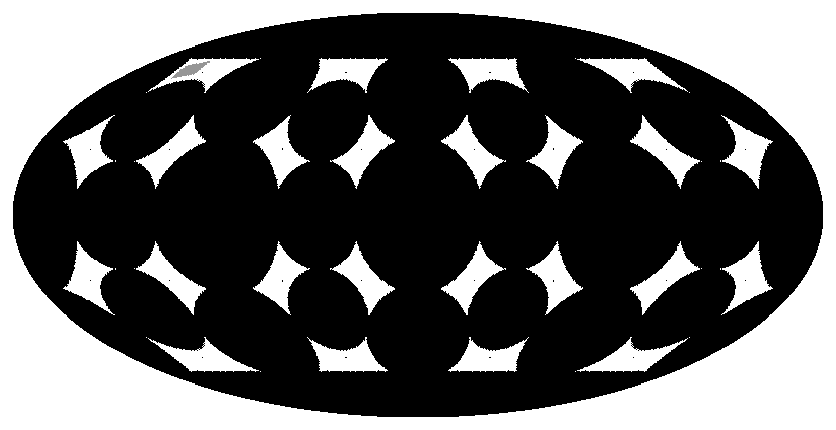

In [73]:
# start with upper left, go across
# region A1
plotregion((1.18, -np.pi/2), 1.11, 1.88)

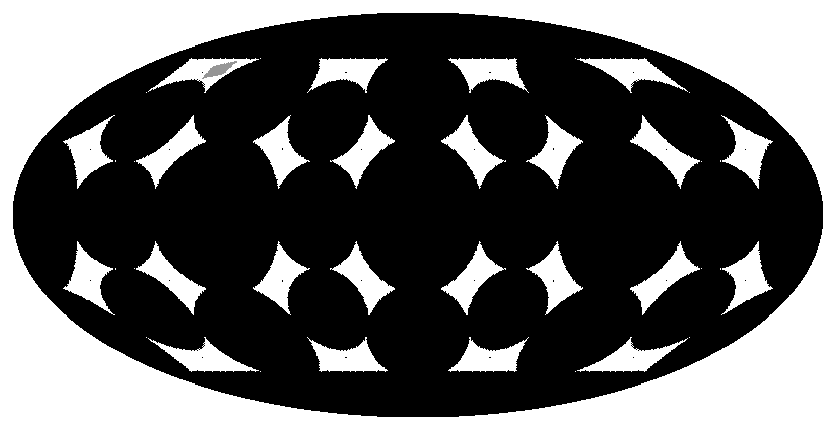

In [71]:
#region A2
plotregion((1.18, -np.pi/2), 1.11, 1.56)

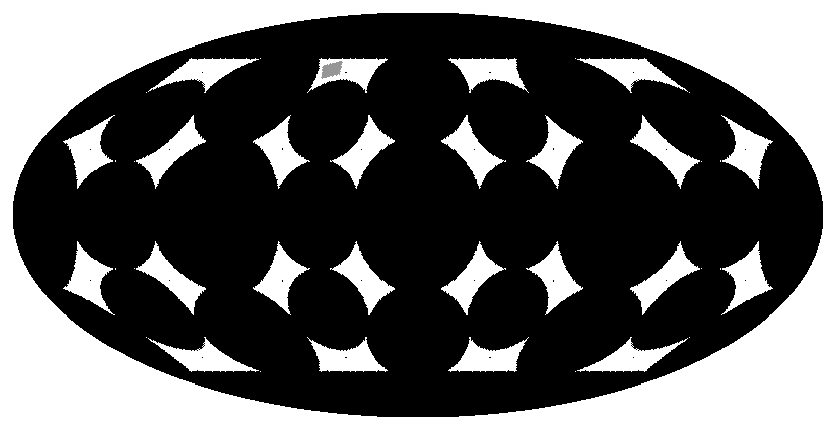

In [69]:
plotregion((1.18, -np.pi/2), 1.11, 0.31)

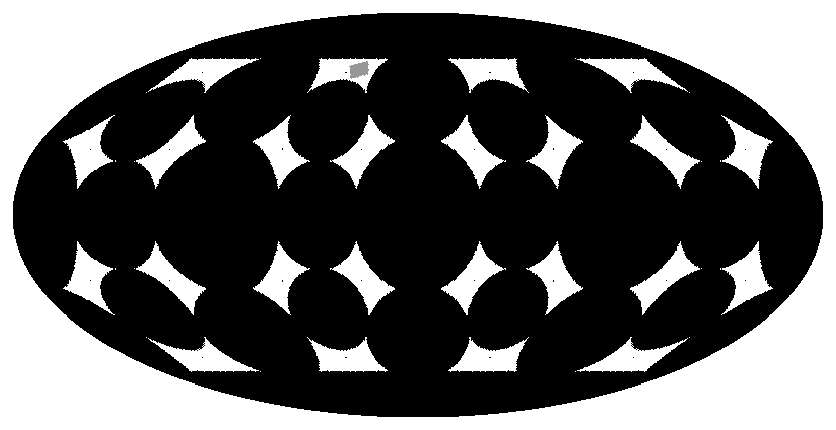

In [66]:
plotregion((1.18, -np.pi/2), 1.11, 0)

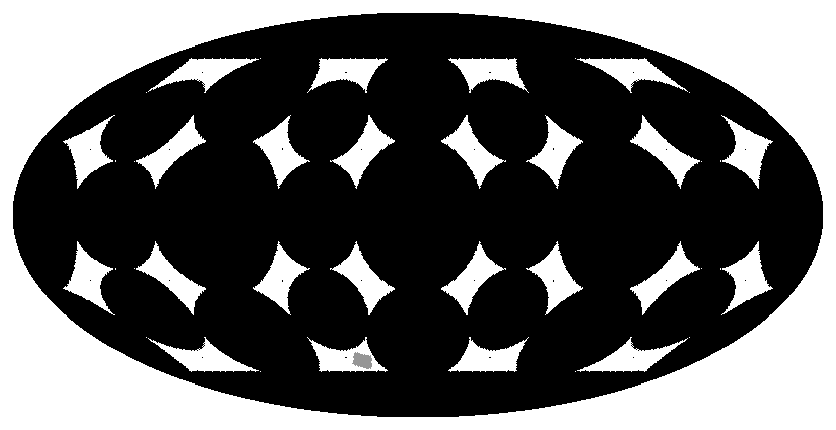

In [61]:
plotregion((1.2, np.pi/2), 1.1, 0)

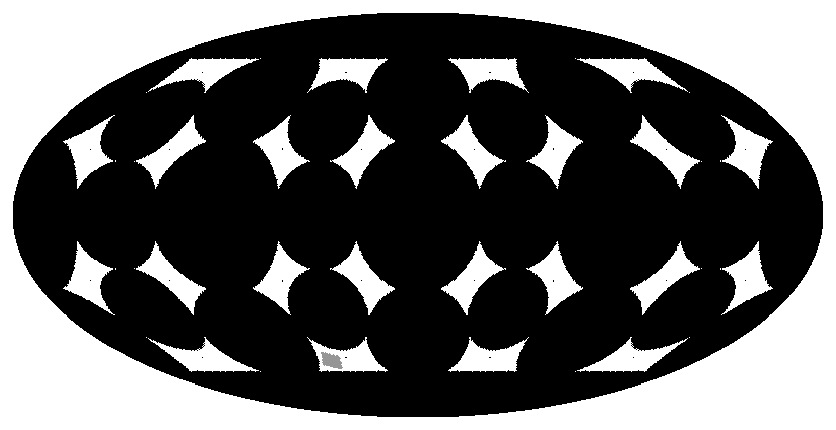

In [41]:
plotregion((1.2, np.pi/2), 1.1, 0.35)

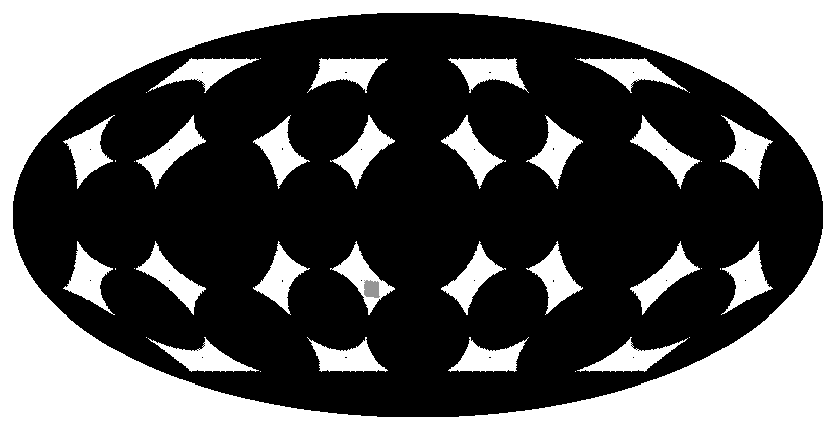

In [27]:
plotregion((0.94, np.pi/2), 0.6, 0)

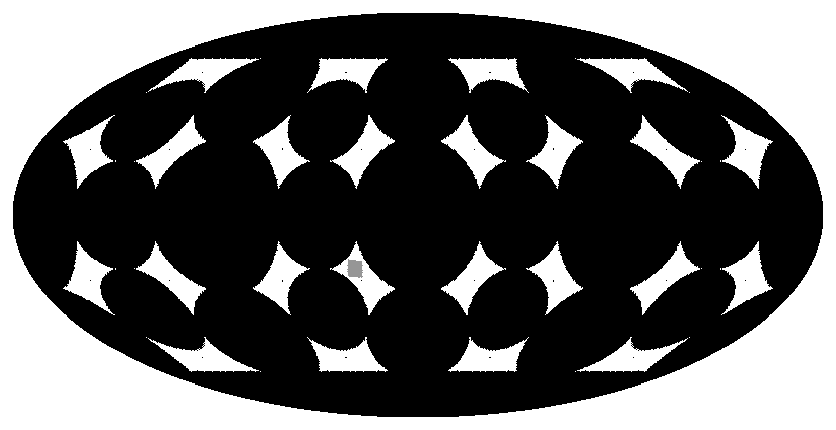

In [30]:
plotregion((0.63, np.pi/2), 0.6, 0)

In [64]:
# smallest resolvable angle

(sim.cosmo.arcsec_per_kpc_comoving(0.4) * sim.binsize * u.kpc / sim.h).to(u.rad)

<Quantity 0.00046153 rad>

In [17]:
np.array(10) + 20

30

In [2]:
0.10 / 0.0008 #let's use this pixel size

125.0

In [4]:
np.vstack((np.ones(3), np.zeros(3))).T

array([[1., 0.],
       [1., 0.],
       [1., 0.]])